## 作业十

### 绘制二维分形图像，并按照图7.23的方式计算分型维度。

In [8]:
# mandelbrot.py

from __future__ import annotations  # Union type syntax
from dataclasses import dataclass
from math import log


@dataclass
class MandelbrotSet:
    max_iterations: int
    escape_radius: float = 2.0

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex, smooth=False, clamp=True) -> float:
        value = self.escape_count(c, smooth) / self.max_iterations
        return max(0.0, min(value, 1.0)) if clamp else value

    def escape_count(self, c: complex, smooth=False) -> int | float:
        z = 0
        for iteration in range(self.max_iterations):
            z = z**2 + c
            if abs(z) > self.escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return self.max_iterations
    
# viewport.py

from dataclasses import dataclass
from PIL import Image


@dataclass
class Viewport:
    image: Image.Image
    center: complex
    width: float

    @property
    def height(self):
        return self.scale * self.image.height

    @property
    def offset(self):
        return self.center + complex(-self.width, self.height) / 2

    @property
    def scale(self):
        return self.width / self.image.width

    def __iter__(self):
        for y in range(self.image.height):
            for x in range(self.image.width):
                yield Pixel(self, x, y)


@dataclass
class Pixel:
    viewport: Viewport
    x: int
    y: int

    @property
    def color(self):
        return self.viewport.image.getpixel((self.x, self.y))

    @color.setter
    def color(self, value):
        self.viewport.image.putpixel((self.x, self.y), value)

    def __complex__(self):
        return (
            complex(self.x, -self.y) * self.viewport.scale
            + self.viewport.offset
        )

### fractal_picture

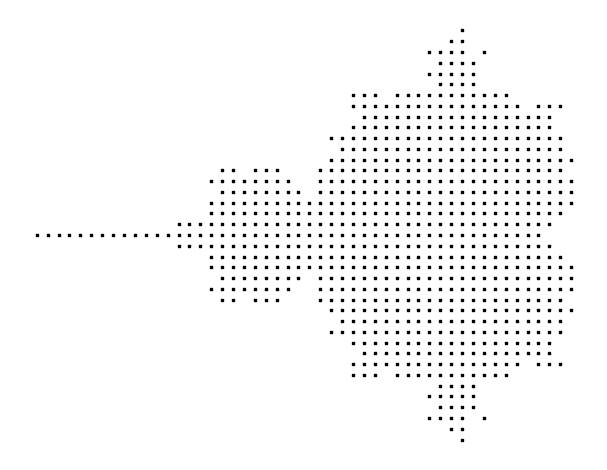

In [57]:
import matplotlib.pyplot as plt
import numpy as np

np.warnings.filterwarnings("ignore")


def complex_matrix(xmin, xmax, ymin, ymax, pixel_density):
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixel_density))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixel_density))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j


def is_stable(c, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = z**2 + c
    return abs(z) <= 2


def get_members(c, num_iterations):
    mask = is_stable(c, num_iterations)
    return c[mask]


if __name__ == "__main__":
    c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=21)
    members = get_members(c, num_iterations=20)

    plt.scatter(members.real, members.imag, color="black", marker=",", s=1)
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

This might take a while...


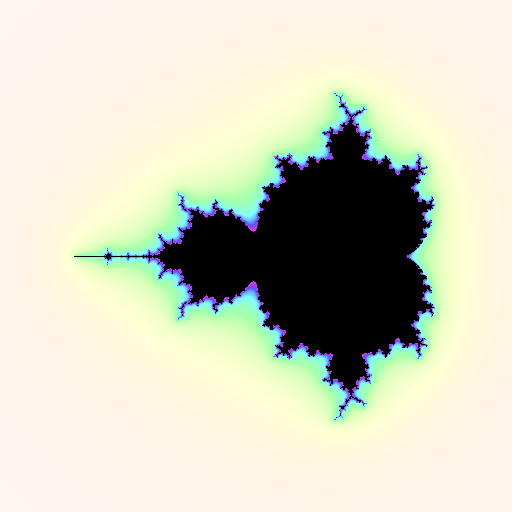

In [22]:
from PIL import Image
from PIL.ImageColor import getrgb


def hsb(hue_degrees: int, saturation: float, brightness: float):
    return getrgb(
        f"hsv({hue_degrees % 360},"
        f"{saturation * 100}%,"
        f"{brightness * 100}%)"
    )


if __name__ == "__main__":
    print("This might take a while...")

    mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
    image = Image.new(mode="RGB", size=(512, 512))
    for pixel in Viewport(image, center=-0.75, width=3.5):
        stability = mandelbrot_set.stability(complex(pixel), smooth=True)
        pixel.color = (
            (0, 0, 0)
            if stability == 1
            else hsb(
                hue_degrees=int(stability * 360),
                saturation=stability,
                brightness=1,
            )
        )

    image.show()

This might take a while...


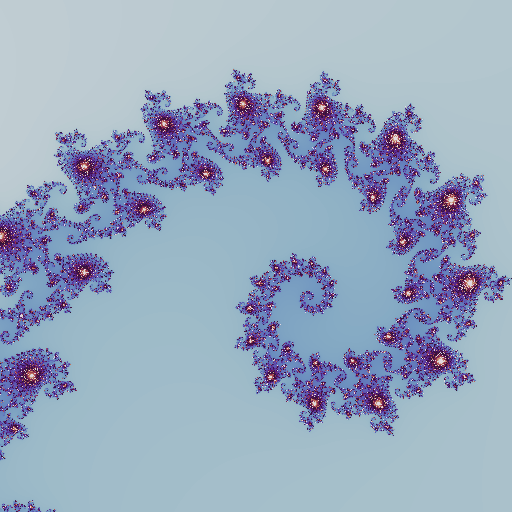

In [28]:
import matplotlib.cm
from PIL import Image


def paint(mandelbrot_set, viewport, palette, smooth):
    for pixel in viewport:
        stability = mandelbrot_set.stability(complex(pixel), smooth)
        index = int(min(stability * len(palette), len(palette) - 2))
        pixel.color = palette[index % len(palette)]


def denormalize(palette):
    return [
        tuple(int(channel * 255) for channel in color) for color in palette
    ]


if __name__ == "__main__":
    print("This might take a while...")

    colormap = matplotlib.cm.get_cmap("twilight").colors
    palette = denormalize(colormap)

    mandelbrot_set = MandelbrotSet(max_iterations=512, escape_radius=1000)
    image = Image.new(mode="RGB", size=(512, 512))
    viewport = Viewport(image, center=-0.7435 + 0.1314j, width=0.002)
    paint(mandelbrot_set, viewport, palette, smooth=True)
    image.show()

### Caulate the fractal dimensionality

In [88]:
import numpy as np
import pylab as pl

def boxcount(Z, k):
    """
    returns a count of squares of size kxk in which there are both colours (black and white), ie. the sum of numbers
    in those squares is not 0 or k^2
    Z: np.array, matrix to be checked, needs to be 2D
    k: int, size of a square
    """
    S = np.add.reduceat(
        np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)  # jumps by powers of 2 squares

    # We count non-empty (0) and non-full boxes (k*k)
    return len(np.where((S > 0) & (S < k * k))[0])


def boxcount_grayscale(Z, k):
    """
    find min and max intensity in the box and return their difference
    Z - np.array, array to find difference in intensities in
    k - int, size of a box
    """
    S_min = np.fmin.reduceat(
        np.fmin.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)
    S_max = np.fmax.reduceat(
        np.fmax.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)
    return S_max - S_min


def fractal_dimension(Z, threshold=0.9):
    """
    calculate fractal dimension of an object in an array defined to be above certain threshold as a count of squares
    with both black and white pixels for a sequence of square sizes. The dimension is the a coefficient to a poly fit
    to log(count) vs log(size) as defined in the sources.
    :param Z: np.array, must be 2D
    :param threshold: float, a thr to distinguish background from foreground and pick up the shape, originally from
    (0, 1) for a scaled arr but can be any number, generates boolean array
    :return: coefficients to the poly fit, fractal dimension of a shape in the given arr
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


def fractal_dimension_grayscale(Z):
    """
    works the same as fractal_dimension() just does not look at counts and does not require a binary arr rather is looks
    at intensities (hence can be used for a grayscale image) and returns fractal dimensions D_B and D_M (based on sums
    and means), as described in https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/Glossary.htm#grayscale
    :param Z: np. array, must be 2D
    :return: D_B and D_M fractal dimensions based on polyfit to log(sum) or log(mean) resp. vs log(sizes)
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    i_difference = []
    for size in sizes:
        i_difference.append(boxcount_grayscale(Z, size))

    # D_B
    d_b = [np.sum(x) for x in i_difference]

    # D_M
    d_m = [np.mean(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs_db = np.polyfit(np.log(sizes), np.log(d_b), 1)
    # Fit the successive log(sizes) with log (mean)
    coeffs_dm = np.polyfit(np.log(sizes), np.log(d_m), 1)

    return -coeffs_db[0], -coeffs_dm[0]


def fractal_dimension_grayscale_DBC(Z):
    """
    Differential box counting method with implementation of appropriate box height selection.
    :param Z: 2D np.array
    :return: fd for a grayscale image
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # get the mean and standard deviation of the image intensity to rescale r
    mu = np.mean(Z)
    sigma = np.std(Z)

    # total number of gray levels, used for computing s'
    G = len(np.unique(Z))

    # scaled scale of each block, r=size(s)
    # TODO -- when to rescale, what should a be
    # when to rescale -- either always or when the pixels in the selected box don't fall in +- 1 std, so far always
    a = 1
    r_prime = sizes / (1 + 2 * a * sigma)

    # Actual box counting with decreasing size
    i_difference = []
    for size in sizes:
        # rescale
        n_r = np.ceil(boxcount_grayscale(Z, size) / r_prime)
        # if max==min per the box, replace the 0 result with 1
        n_r[n_r == 0] = 1
        i_difference.append(n_r)

    # contribution from all boxes
    N_r = [np.sum(x) for x in i_difference]
    
    data=np.log(sizes)
    data1=np.log(N_r)
    print(sizes)
    '''
    # Fit the successive log(sizes) with log (sum)
    coeffs = np.polyfit(np.log(sizes), np.log(N_r),1)
    pl.plot(np.log(sizes),np.log(N_r), 'o', mfc='none')
    pl.plot(np.log(sizes), np.polyval(coeffs,np.log(sizes)))
    pl.xlabel('log $\epsilon$')
    pl.ylabel('log N')
    return -coeffs[0]
    '''

In [99]:
z1=np.array([members.real,members.imag])
z2=np.array([[0.5, -0.5, 0.5, 0.5, 0.0, 0.0, 0.5],[0.5, 0.5, -0.5, 0.5, 0.5, 0.5, 0.5]])
k1=2
k2=2
print(z1)
boxcount(z1,k1)
boxcount(z2,k2)
boxcount_grayscale(z1,k1)
#fractal_dimension(z1, threshold=0.9)
#fractal_dimension_grayscale(z1)
#fractal_dimension_grayscale_DBC(z2)

[[-0.08823529 -0.1372549  -0.08823529 ... -0.1372549  -0.08823529
  -0.08823529]
 [-0.91935484 -0.87096774 -0.87096774 ...  0.87096774  0.87096774
   0.91935484]]


array([[0.83111954, 0.78273245, 0.68532574, 0.83238457, 0.63693865,
        0.73497786, 0.53953194, 0.63757116, 0.68659077, 0.58918406,
        0.63820367, 0.1486401 , 0.29569892, 0.39373814, 0.49177736,
        0.58981657, 0.68785579, 0.7368754 , 0.100253  , 0.19829222,
        0.29633144, 0.39437065, 0.49240987, 0.59044908, 0.6884883 ,
        0.83554712, 0.93358634, 0.05186591, 0.14990512, 0.24794434,
        0.34598355, 0.44402277, 0.54206199, 0.6401012 , 0.73814042,
        0.83617963, 0.0945604 , 0.05249842, 0.15053763, 0.24857685,
        0.34661607, 0.44465528, 0.5426945 , 0.64073371, 0.73877293,
        0.98039216, 0.19196711, 0.09392789, 0.05313093, 0.15117015,
        0.24920936, 0.34724858, 0.44528779, 0.54332701, 0.64136622,
        0.73940544, 0.98039216, 0.1913346 , 0.09329538, 0.05376344,
        0.15180266, 0.24984187, 0.34788109, 0.4459203 , 0.54395952,
        0.64199873, 0.74003795, 0.33776091, 0.2397217 , 0.14168248,
        0.04901961, 0.10341556, 0.20145478, 0.29

749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 2
749 

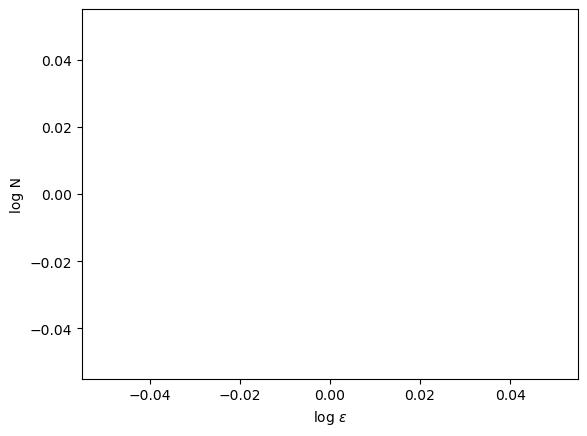

In [100]:
image=np.array(z1)
pixels=[]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i,j]>0:
            pixels.append((i,j))
            Lx=image.shape[1]
            Ly=image.shape[0]
            print (Lx, Ly)
pixels=np.array(pixels)
print (pixels.shape)
scales=np.logspace(0.01, 1, num=10, endpoint=False, base=2)
Ns=[]
for scale in scales:
    print ("======= Scale :",scale)
    H, edges=np.histogramdd(pixels, bins=(np.arange(0,Lx,scale),np.arange(0,Ly,scale)))
    Ns.append(np.sum(H>0))
coeffs=np.polyfit(np.log(scales), np.log(Ns), 1)
pl.plot(np.log(scales),np.log(Ns), 'o', mfc='none')
pl.plot(np.log(scales), np.polyval(coeffs,np.log(scales)))
pl.xlabel('log $\epsilon$')
pl.ylabel('log N')
pl.savefig('sierpinski_dimension.pdf')
print ("The Hausdorff dimension is", -coeffs[0]) #the fractal dimension is the OPPOSITE of the fitting coefficient
np.savetxt("scaling.txt", list(zip(scales,Ns)))